# Create parameters for probe extraction
This notebook should allow easy extraction of the data, walking through each of the parameters that my code requires.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0,8.0]
import matplotlib.pyplot as plt
import os



## Path to the code
This is the path to where the git repository has been stored.

In [2]:
import sys
# sys.path.insert(0, '/Users/chrisunderwood/Documents/Experimental_Tools/Interferometry_extraction/')
from Interferometry_Extraction import Interferometry

### Enter the file path below to test the code on.

In [5]:
rootExperimentFolder = "/Volumes/Lund_York/"
dayFolder = "2019-11-15/"
runFolder = dayFolder + "0001/"
diagName = "Interferometer/"

fileName = rootExperimentFolder + runFolder + diagName + "0001_0195_Interferometer.tif"
referenceImage = rootExperimentFolder + dayFolder + diagName + "20191115FringesNoPlasma.tiff" #"20190724/run003/Shot1.tiff"

Load the file 

In [6]:
if not os.path.exists(fileName):
    print (fileName, os.path.exists(fileName))
if os.path.exists(fileName):
    try:
        print ("\n\nOpening file: ", fileName)
        analysis = Interferometry()
        analysis.load_data_from_file(fileName)
        # analysis.plotRawImage()
        analysis.loadReference(referenceImage)
    except ValueError:
        print ("Error With File", fileName, i)




Opening file:  /Volumes/Lund_York/2019-11-15/0001/Interferometer/0001_0195_Interferometer.tif
Loading .tif
Loading .tiff/TIFF


# Crop to the plasma channel, or other region of interest

The padding x and y is for the hamming window. These need to be large enough not to get sharp edge effects.
The padSize is to increase the spacing in Fourier space of the fring shifts.

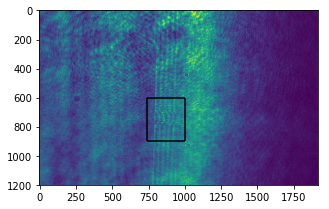

Creating Gaussian To Crop. Image shape (1200, 1920)
Plotting the raw images cropped with a window


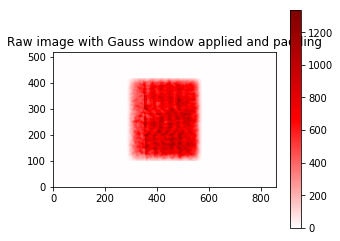

In [8]:
#plasmaChannel=[bottom, top, left, right] # Remeber the position of the origin for top and bot
plasmaChannel=[600, 900, 740, 1000]
paddingX = 200
paddingY = 10
padSize = 100
analysis.crop_plasma_channel(plasmaChannel=plasmaChannel, 
                             paddingX = paddingX, paddingY = paddingY, padSize = padSize,
                             plotting = True)


## Select one of the side peaks in fourier space to crop to.
If the coordinates are given it crops to that.
If it is None, then it searchs for it itself, and the four numbers it returns can be used next time.

Using Given Crop Region  [150, 350, 443, 470]
Creating Gaussian To Crop. Image shape (520, 860)
Peaks in f space (array([403, 422, 425, 430, 435, 438, 457]), {'peak_heights': array([2.30095500e+07, 2.43709542e+07, 3.96230515e+07, 1.93628057e+08,
       3.96230515e+07, 2.43709542e+07, 2.30095500e+07])})


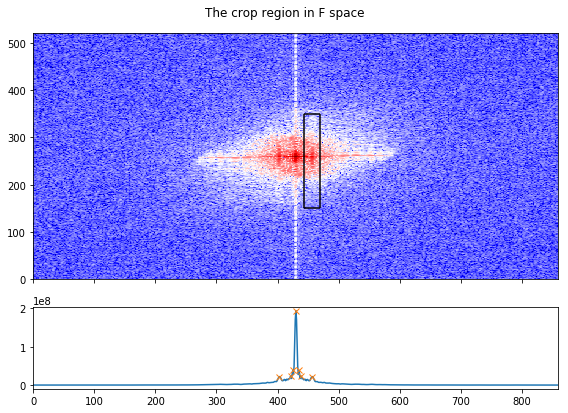

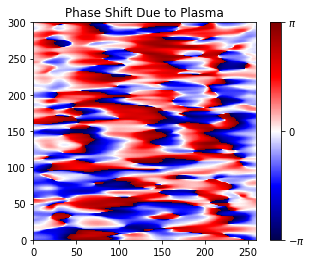

Phase Produced


[150, 350, 443, 470]

In [11]:
# fftCropRegion = None
# [bottom, top, left, right] 
fftCropRegion = [150, 350, 443, 470]

analysis.createPhase(fftCropRegion,
                     peakRelHeight = 0.1,
                     plotCropFFTPeak = False, 
                     plot_fft_plasma = False,# This one should always be false as fft_space is better
                     plot_fft_space = True,
                     plot_final_result = True)

### Unwrap the phase.
Making the assumption that the phase shift is positive to remove any background phase effects.
Fit the phase to check it is positive and invert if not.

The angle of the plasma channel is selected by finding the peak location for each column of the image.
Enter the start pixels and end pixels of the plasma channel so it doesn't get confused by the noise at either end.
    The two variables are:
        angle_arr_start
        angle_arr_end
        
The thresholds are for find the peaks, and also createing a mask around the channel. These may need to be tuned.

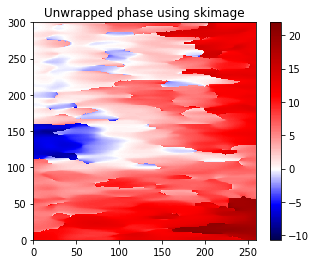

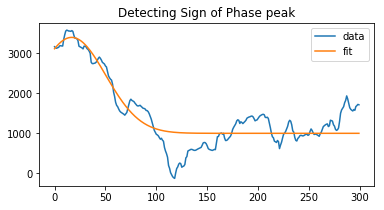

Fit failed of gaussian to phase peak
117 135
40 65 40 65
Straight line guess [0, 24.52]


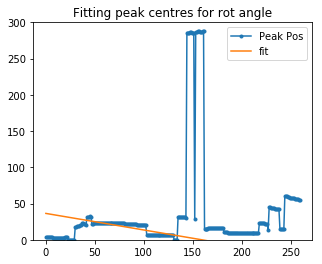

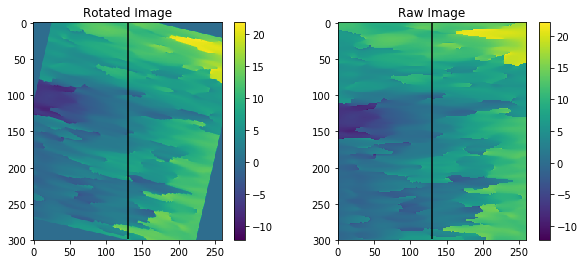

Angle Rotated:  -12.869017791226966


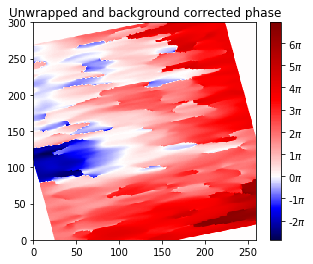

In [12]:
angle = False
# angle = 2.65732995

angle_arr_start = 40
angle_arr_end  = 65
mask_threshold_level = 0.5

# Unwrapping unwraps the phase, and then does some background 
# manipulation so the surrounding phase is zero, and the shift is positive
rotationAngle = analysis.unwrap_raw_phase(angle = angle, angle_arr_start = angle_arr_start, angle_arr_end  = angle_arr_end,
                        plotSkimage = True, plotOutput = True, plotInverting = True,
                        plotMask = False,
                        plot_linfit = True, plot_rotation = True, 
                        mask_threshold_level = mask_threshold_level)
    

### Enter the pixel size

An abel method could be chosen too, but they all seem to produce the same result.

Gaussian center at (206.02889858161103, 33.92489933202153)
delta = (-76.02889858161103, 115.07510066797846)
Taking average lineout in region of size 0.1992428mm around axis
(300, 260) -20.0
(300, 260) 20.0


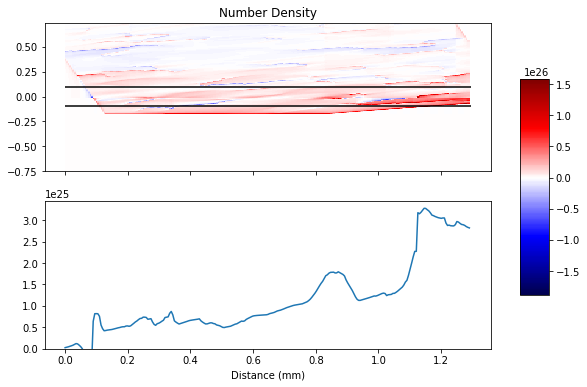

In [13]:
mPerPix = 4.98107e-06

abelMethods = ["hansenlaw", "direct", "basex","two_point",
               "three_point","onion_peeling","onion_bordas"]
img, lineout = analysis.recreateElectronDensity(
                     mPerPix = mPerPix, # mPerPix = 6.25e-06,                                        
                     pixelsAroundPlasmaChannel = 20,
                     abelMethod = abelMethods[0],
                     plot_n_e = True
                     )

## Write the output in a form that can go into the csv file.
Record all the parameters used, so this can go into the next extraction.

In [ ]:
    # Items to save!
day = runFolder.split("/")[0]
run = runFolder.split("/")[1]
burst = burstFolder.split("/")[-2]
shot = fileName.split("/")[-1]
ref = referenceImage

sys.path.insert(0, '/Users/chrisunderwood/Documents/Experimental_Tools/Interferometry_extraction/Experimental_Databases/')
from  TA2_HRR_Streeter_Inteferometery_DB import probeDatabase 
savePath = "/Volumes/GoogleDrive/My Drive/2019_Streeter_TA2/Probe_Interferometry/"
file_Probe_Database = "TA2_HRR_Probe_Database.csv"
pdb = probeDatabase(savePath + file_Probe_Database)

pdb.create_string_to_write(day, run, burst, shot, ref, plasmaChannel, paddingX, paddingY, padSize, fftCropRegion,
       rotationAngle, mPerPix, mask_threshold_level)
pdb.save_line_to_file()


In [ ]:
fftCropRegion